<a href="https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/11_How_to_train_big_arrays_faster_with_tsai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

# Purpose 😇

> In this notebook, we'll demonstrate how you can efficiently train a larger-than-memory dataset using **tsai**.

**Interested in speeding up training on larger-than-memory datasets?**

If you want train your models fast you need to have a good / multiple good GPUs. No question about that. 

But even the best GPU will crawl if your batch creation process is slow. Only when the dataloaders create batches faster than the GPU consumes them, you'll achieve 100% GPU usage. And shorter training times. This is particularly important with larger-than-memory datasets.

In this notebook we'll show you how to create really fast dataloaders to speed up your training.




# Import libraries 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
from tsai.all import *
import zarr
my_setup(zarr)

os             : Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.11
tsai           : 0.2.23
fastai         : 2.5.2
fastcore       : 1.3.26
zarr           : 2.9.5
torch          : 1.9.0+cu102
n_cpus         : 2
device         : cuda (Tesla T4)


# Zarr arrays ☦️

In addition to tsai, we'll make also need a library called [zarr](https://zarr.readthedocs.io). 


Zarr is a format for the storage of chunked, compressed, N-dimensional arrays. These documents describe the Zarr format and its Python implementation.

**Highlights**

- Create N-dimensional arrays with any NumPy dtype.
- Chunk arrays along any dimension.
- Compress and/or filter chunks using any NumCodecs codec.
- Store arrays in memory, on disk, inside a Zip file, on S3, …
- Read an array concurrently from multiple threads or processes.
- Write to an array concurrently from multiple threads or processes.
- Organize arrays into hierarchies via groups.

## Want to know more about zarr arrays?

We are going to briefly understand how we can use zarr arrays. Let's prepare a relatively small dataset that fits in memory. 

Note: For a more in-depth understanding of zarr arrays you can visit this [tutorial](https://zarr.readthedocs.io/en/stable/tutorial.html).

In [ ]:
path = Path('data')
if not os.path.exists(path): os.makedirs(path)

In [ ]:
arr = np.random.rand(10_000, 10, 100)
np.save(path/'arr.npy', arr)

We know that one of the data formats we can use for large datasets are memory-mapped arrays (np.memmap). They behave like normal arrays, except that they remain on disk. When you index them, only those indices are loaded in memory. That's great because it's what we need to create batches in tsai.

In [ ]:
memmap_arr = np.load(path/'arr.npy', mmap_mode='r+')
memmap_arr.shape

(10000, 10, 100)

### Create an on-disk zarr array & load data

For large datasets, we need to create an zarr array on disk. The array will initially be empty, with all values set to 0.

In [ ]:
zarr_arr = zarr.open(path/'zarr.zarr', mode='w', shape=arr.shape, dtype=arr.dtype)
zarr_arr

<zarr.core.Array (10000, 10, 100) float64>

They are array-like objects, like memmap arrays

In [ ]:
hasattr(memmap_arr, '__array__'), hasattr(zarr_arr, '__array__')

(True, True)

Although they are not np.ndarrays

In [ ]:
isinstance(memmap_arr, np.ndarray), isinstance(zarr_arr, np.ndarray)

(True, False)

To load data into the array we can: 

- assign it directly if the data fits in memory or if data is stored in a memmap array on disk: 


In [ ]:
zarr_arr[:] = memmap_arr

- we can split data in chunks that fit memory. We can load data from an array, a dataframe, etc. 

In [ ]:
chunksize = 1_000

for i in range(len(memmap_arr) // chunksize + 1):
    zarr_arr[i * chunksize : (i + 1) * chunksize] = memmap_arr[i * chunksize : (i + 1) * chunksize]

There is a function in `tsai` that helps you assign data in chunks in place:

In [ ]:
assign_in_chunks(zarr_arr, memmap_arr, chunksize=10_000, inplace=True, verbose=True)

Once you load data, if you want to ensure your data is never modified, you may load the zarr array in mode 'r' (read only). This process is fast.

Otherwise you can continue working with your array in mode 'w'.

Note: even if zerr.open seems to indicate the opposite, there's no need to ever close zarr arrays. You can just delete as a regular array, and recursively remove if from its directory (if on disk).

In [ ]:
zarr_arr = zarr.open(path/'zarr.zarr', mode='r')

### How to slice a zarr array?

Let's now create some indices to index the arrays. 

Indexing is used to obtain individual elements from an array. In tsai, it's used to create batches of data by the dataloader. 

In [ ]:
idxs = random_choice(len(arr), 64, False)

In [ ]:
arr[idxs].shape, memmap_arr[idxs].shape

((64, 10, 100), (64, 10, 100))

When memmap arrays are index, the index elements become a regular np.array. 

In [ ]:
type(arr[idxs]), type(memmap_arr[idxs])

(numpy.ndarray, numpy.ndarray)

Zarr arrays are unique in the way they need to be indexed.

If we try to apply indices in the same way as with memmap arrays, you'll get an error message.

Zarr arrays have an attribute called 'oindex' that is used to index the array.

In [ ]:
hasattr(zarr_arr, 'oindex')

True

In [ ]:
zarr_arr.oindex[idxs].shape, type(zarr_arr.oindex[idxs])

((64, 10, 100), numpy.ndarray)

In [ ]:
np.array_equal(arr[idxs], memmap_arr[idxs]), np.array_equal(arr[idxs], zarr_arr.oindex[idxs])

(True, True)

tsai supports many types of array-like objects, like numpy arrays, memmap arrays, zarr arrays, xarrays, dask arrays, and even lists or L objects. 

That means you can use any of those types as data inputs. 

# In-memory datasets 🧠

Let's compare the performance of the 3 types of arrays we have created (np.array, np.memmap, zarr). They all fit in memory, although for comparison, np.memmap and zarr data are on disk. 

In [ ]:
%timeit arr[random_choice(len(arr), 512, False)]

1000 loops, best of 5: 1.33 ms per loop


In [ ]:
%timeit memmap_arr[random_choice(len(arr), 512, False)]

1000 loops, best of 5: 1.33 ms per loop


Now we'll create a zarr array. Since the array fits in memory, we'll set chunks to False, meaning no chunking will be applied. 

In [ ]:
zarr_arr = zarr.open(path/'zarr.zarr', mode='w', shape=arr.shape, dtype=arr.dtype, chunks=False) 
zarr_arr[:] = arr 
zarr_arr, zarr_arr.chunks

(<zarr.core.Array (10000, 10, 100) float64>, (10000, 10, 100))

In [ ]:
%timeit zarr_arr.oindex[random_choice(len(arr), 512, False)]

10 loops, best of 5: 63 ms per loop


⚠️ In order to improve performance, it's beneficial for zarr arrays to sort the indices. 

In [ ]:
%timeit zarr_arr.oindex[np.sort(random_choice(len(arr), 512, False))]

10 loops, best of 5: 60.6 ms per loop


We have learned 2 things: 

- For datasets that fit in memory, both numpy arrays and zarr arrays are very fast. Memmap arrays are slower.

- Chunks have a great impact on zarr arrays performance. Always choose chunks=False for datasets that fit in memory. 

⚠️ chunks=False means a single data containing all data in the dataset. We can only do this when data fits in memory. 

# Larger-than-memory datasets 🤯

We are going to create a larger-than_memory file with **dummy data**. 

Colab Pro (standard) has 13GB of RAM. However, the X_large file has 37GB. So we'll need to manage everything on disk.

Data creation will take around 10 min.


⚠️ Remember to delete this file when you finish!

In [ ]:
path = Path('data')

In [ ]:
# Uncomment to create the data
# X_large = create_array((1_000_000, 10, 1000), fname='X_large', path='data', mode='r+')
# del X_large

In [ ]:
X_large = np.load(path/'X_large.npy', mmap_mode='r+')
X_large.shape

(1000000, 10, 1000)

In [ ]:
y_large = np.array(['a', 'b', 'c'])[np.random.randint(0, 3, len(X_large))]
np.save(path/'y_large.npy', y_large)
del y_large
y_large = np.load(path/'y_large.npy', mmap_mode='r+')
y_large

memmap(['b', 'b', 'a', ..., 'a', 'c', 'c'], dtype='<U1')

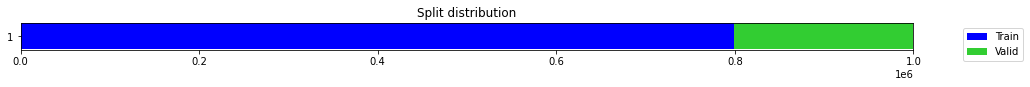

In [ ]:
splits = TimeSplitter()(y_large)

Let's see what's the performance of memmap arrays when they are indexed (simulating a batch creation process): 

In [ ]:
np_res = %timeit -qo X_large[random_choice(len(X_large), 512, False)]
np_res

<TimeitResult : 1 loop, best of 5: 1.72 s per loop>

Let's now create a zarr array on disk with the same shape. In this case, since data doesn't fit in memory, we are going to use chunks to be able to improve performance. The recommended approach is to set chunks != -1 in the dimension we are going to use (in our case the first dimension). That's why we set chunks=(1, -1,-1),
For an in-depth review on chunks you can read [this](https://docs.dask.org/en/latest/array-chunks.html).

When creating a zarr array we need to use mode='a' (read if exist, otherwise write) or 'w' (always write or overwrite). There's no need to ever close the array. 

When an array's been created, you can always read it again bu setting mode='r'.

This step will also take about 10 min.

⚠️ Note that chunks stands for “chunk shape” rather than “number of chunks”, so specifying chunks=1 means that you will have many chunks, each with exactly one element.

In [ ]:
# X_large_zarr = zarr.open(path/'X_large.zarr', mode='w', shape=X_large.shape, dtype=X_large.dtype, chunks=(1, -1, -1)) # chunks=(1, -1, -1) == (1, None, None)
# X_large_zarr[:] = X_large

In [ ]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='r')
X_large_zarr

<zarr.core.Array (1000000, 10, 1000) float32>

In [ ]:
zarr_res = %timeit -qo X_large_zarr.oindex[random_choice(len(X_large), 512, False)]
print(f'{zarr_res.best:.2f}s which is {1 - zarr_res.best/np_res.best:.1%} less')

1.31s which is 24.0% less


Excellent!!! 🙃 I'm starting to really like zarr arrays!!!

One more idea. Zarr arrays are a bit faster when the indices are sorted. Let's try it: 

In [ ]:
zarr_sorted_res = %timeit -qo X_large_zarr.oindex[np.sort(random_choice(len(X_large), 512, False))]
print(f'{zarr_sorted_res.best:.2f}s which is {1 - zarr_sorted_res.best/np_res.best:.1%} less')

1.19s which is 30.8% less



This is an excellent performance for a large, on-disk dataset like this. Indexing is around 30% faster than memmap arrays!!! 🚀

Zarr arrays are very useful when dealing with larger-then-memory datasets.

There are some important concepts to unsertand why zarr arrays are faster to index: 

- Chunks are parts of the array that are loaded in memory at the same time. This makes indexing more efficient. 

- Zarr arrays are compressed. This also improves the loading of data in memory. 

- Zarr arrays can be concurrently read and written by multiple threads or processes.

## Key learnings: 

- For datasets that fit in memory, use numpy arrays (or np.memmap arrays). 

- For larger than memory datasets, use zarr arrays. 

- Set up chunks=(1, -1, -1)

- Sort the indices before indexing the array. 


The tsai library applies all these learnings to achieve the fastest possible performance for larger-than-memory datasets.

# Training  🏃🏽‍♀️

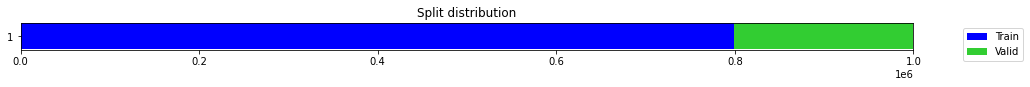

In [ ]:
X_large_zarr = zarr.open(path/'X_large.zarr', mode='r') # mode='r' because we are reasing the zarr array we previously created
y_large_zarr = zarr.open(path/'y_large.zarr', mode='w', shape=y_large.shape, dtype=y_large.dtype, chunks=False) # y data is small and don't need to be chunked
y_large_zarr[:] = y_large
splits = TimeSplitter()(y_large)

When creating the dataloaders, there are 2 important things to remember:

1. If you are dealing with a classification task and need to transform the lavels, use TSClassification. It's vectorized version of Categorize that run much faster.

2. Set inplace to False. This is required when the data doesn't fit in memory. If you don't use it your system will crash and you will need to start again. 

3. Increasing num_workers=cpus may also reduce the training time. 


⚠️ Note: bear in mind we are using dummy data. We are not intereted in accuracy. We are interested in time/epoch.

## np.memmap

I've tried different num_workers, but num_workers=0 and num_workers=cpus seem to have the same performance. 

⚠️ if you are running this notebook on Windows changing num_workers won't have any effect, as it will be disabled with this message: **Due to IPython and Windows limitation, python multiprocessing isn't available now.**

epoch,train_loss,valid_loss,accuracy,time
0,1.098613,1.098612,0.333885,1:06:40


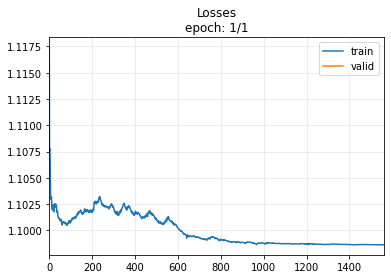

not enough values to plot a chart
Total time        : 1:06:40.556316


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large, y_large, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=0)
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

epoch,train_loss,valid_loss,accuracy,time
0,1.098606,1.098651,0.332850,1:07:33


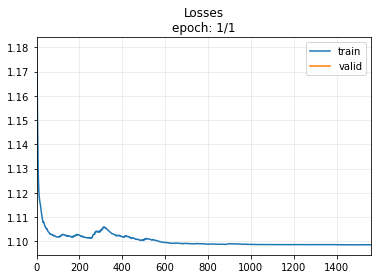

not enough values to plot a chart
Total time        : 1:07:33.940965


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large, y_large, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=cpus)
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

In this case, GPU utilization is very variable, although a lot of the time stays at 0%. That is because the dataloader takes time to build the batches because indexing is pretty slow with np.memmap arrays with such a large dataset.

## zarr arrays

We recommend to set num_workers = cpus. That will significantly speed up your training, as zarr array reading can be done in parallel.

epoch,train_loss,valid_loss,accuracy,time
0,1.098604,1.098629,0.332995,46:36


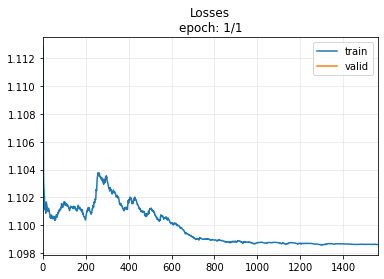

not enough values to plot a chart
Total time        : 0:46:37.044966


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=0)
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

epoch,train_loss,valid_loss,accuracy,time
0,1.098617,1.098628,0.332385,26:06


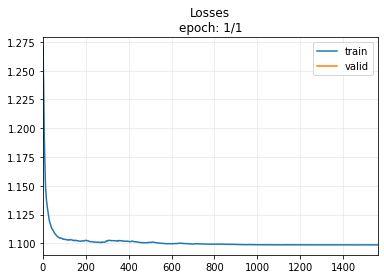

not enough values to plot a chart
Total time        : 0:26:07.003129


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=2) # 1*cpus
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

epoch,train_loss,valid_loss,accuracy,time
0,1.098602,1.098624,0.332375,24:27


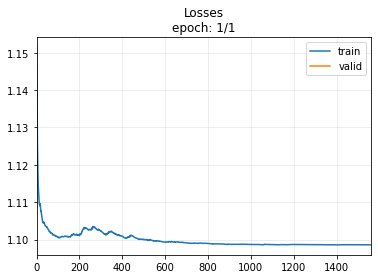

not enough values to plot a chart
Total time        : 0:24:28.079497


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=4) # 2*cpus
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

epoch,train_loss,valid_loss,accuracy,time
0,1.098634,1.098615,0.333735,24:30


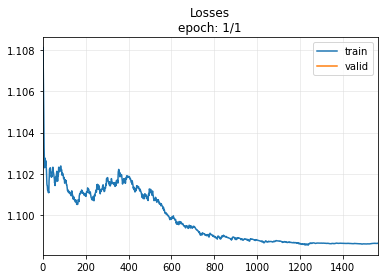

not enough values to plot a chart
Total time        : 0:24:31.011945


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=8) # 4*cpus
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(1, 1e-2)
timer.stop()

That's great. An interesting finding is that most of the time the GPU utilization is 100%. This means the batch creation process is no longer a bottleneck. That's why speed is much faster. To further reduce time, we'd need a better GPU and/ or multiple GPUs.

Setting num_workers>0 helps a lot because the bottleneck is batch creation, not the GPU. 

In any case, the goal is to ensure maximum utilization of your GPU. You can easily get a view of GPU utilization by running this code in your terminal during training: 

```
watch -n .2 nvidia-smi
```

I've run some additional tests (look below) to measure the impact of number of workers on a dataloader that uses memmap arrays vs zarr arrays. Here are the findings: 

- memmap arrays with num_workers > 0 degrades performance
- zarr arrays with num_workers > 0 improves performance

Remember that zarr arrays can be read in parallel while memmap arrays can't. 

<img src="https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/images/ZarrvsMemmap.png?raw=true"  width="500">

# Conclusion ✅

In this notebook we have learned how we can train a model with a large dataset in tsai. By using zarr arrays,  setting the chunks parameter to (1,-1,-1) aand num_workers>0, we can really speed up training 2.5x!!

Key points: 

- if you dataset fits in memory, use np.arrays (or np.memmap).
- if your dataset doesn't fit in memory, our recommended format is zarr with chunks = (1, None, None)
- You should also try setting num_workers>0, as zarr arrays support parallel computing (which means that multiple concurrent read operations may occur). This usually improves performance too. 
- By using all this you'll be able to significantly reduce your training time when using out-of-memory datasets. 
- `tsai` currently supports multiple input data types, including: 

   * np.ndarray
   * list
   * L
   * np.memmap
   * dask.array
   * xarray
   * zarr

   The last 4 have the benefit that they can be used on-disk (out-of-core learning), with larger-than-memory datasets.

We hope you've find this tutorial useful. If you have any questions/ issues don't hesitate to visit [tsai](https://github.com/timeseriesAI/tsai) in GitHub!!

# Additional tests 🥴

We already know that it's faster to index large zarr arrays compared to memmap arrays. 

In [ ]:
%timeit X_large[np.sort(random_choice(len(X_large_zarr), 512, False))]

1 loop, best of 5: 1.78 s per loop


In [ ]:
%timeit X_large_zarr.oindex[np.sort(random_choice(len(X_large_zarr), 512, False))]

1 loop, best of 5: 1.27 s per loop


But another key difference is multiprocessing. 

Zarr arrays can be read in parallel by multiple workers, while memmap arrays can't. This means that when we increase num_workers with memmap arrays we usually see a drop in performance. However, performance improves considerably when using num_workers > 0 with zarr arrays.

In [ ]:
def cycle_dl_estimate(dl, iters=10):
    iters = min(iters, len(dl))
    iterator = iter(dl)
    timer.start(False)
    for _ in range(iters): next(iterator)
    t = timer.stop()
    return (t/iters * len(dl)).total_seconds()

In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large, y_large, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=0)
train_dl = dls.train
valid_dl = dls.valid

In [ ]:
for nw in [0, 1, 2, 4, 8]:
    train_dl.fake_l.num_workers = nw
    print(f'{nw:2} {cycle_dl_estimate(train_dl)/60:.1f}')

 0 44.2
 1 67.7
 2 71.4
 4 87.7
 8 114.7


In [ ]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_large_zarr, y_large_zarr, splits=splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=[512, 1_024], num_workers=0)
train_dl = dls.train
valid_dl = dls.valid

In [ ]:
for nw in [0, 1, 2, 4, 8]:
    train_dl.fake_l.num_workers = nw
    print(f'{nw:2} {cycle_dl_estimate(train_dl)/60:.1f}')

 0 49.1
 1 35.0
 2 26.4
 4 30.6
 8 40.4
